In [21]:
import os
import random
from collections import Counter, defaultdict, deque
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import gaussian_filter1d
import torch.optim as optim
from torchvision import models
from torchvision import transforms

In [17]:
def load_image_sequences(root_dir, stack_size=5):
    sequences = []
    for subject in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject)
        if not os.path.isdir(subject_path):
            continue
        for label in os.listdir(subject_path):
            label_path = os.path.join(subject_path, label)
            if not os.path.isdir(label_path):
                continue
            for action in os.listdir(label_path):
                action_path = os.path.join(label_path, action)
                if not os.path.isdir(action_path):
                    continue
                image_paths = sorted(glob(os.path.join(action_path, '*.jpg')))
                # Pastikan cukup frame untuk stacking
                if len(image_paths) < stack_size:
                    continue
                # Ekstrak nama aksi tanpa angka depan jika ada
                action_name = "_".join(action.split('_')[1:]) if '_' in action else action
                sequences.append({
                    'subject': subject,
                    'label': label,
                    'action': action_name,
                    'image_paths': image_paths
                })
    return sequences

In [18]:
root_dir = '/kaggle/input/data-slayer123/train/train'  
sequences = load_image_sequences(root_dir, stack_size=5)

fall_sequences = [s for s in sequences if s['label'] == 'fall']
non_fall_sequences = [s for s in sequences if s['label'] == 'non_fall']

train_fall, test_fall = train_test_split(fall_sequences, test_size=0.2, random_state=42)
train_non_fall, test_non_fall = train_test_split(non_fall_sequences, test_size=0.2, random_state=42)

train_sequences = train_fall + train_non_fall
test_sequences = test_fall + test_non_fall

# Verifikasi distribusi label
train_labels = [s['label'] for s in train_sequences]
test_labels = [s['label'] for s in test_sequences]

print("Train label distribution:", Counter(train_labels))
print("Test label distribution:", Counter(test_labels))

Train label distribution: Counter({'fall': 19, 'non_fall': 19})
Test label distribution: Counter({'fall': 5, 'non_fall': 5})


In [19]:
def get_action_distribution(sequences):
    action_counts = defaultdict(int)
    action_subjects = defaultdict(set)
    for s in sequences:
        action = s['action']
        action_counts[action] += 1
        action_subjects[action].add(s['subject'])
    return action_counts, action_subjects

train_action_counts, train_action_subjects = get_action_distribution(train_sequences)
test_action_counts, test_action_subjects = get_action_distribution(test_sequences)

def print_action_distribution(action_counts, action_subjects, dataset_name):
    print(f"\n{dataset_name} Action Distribution:")
    print(f"{'Action':<30} {'Count':<10} {'Number of Subjects':<20}")
    print("-" * 60)
    for action, count in action_counts.items():
        num_subjects = len(action_subjects[action])
        print(f"{action:<30} {count:<10} {num_subjects:<20}")

print_action_distribution(train_action_counts, train_action_subjects, "Train")
print_action_distribution(test_action_counts, test_action_subjects, "Test")


Train Action Distribution:
Action                         Count      Number of Subjects  
------------------------------------------------------------
left_falls                     3          3                   
standing_falls                 3          3                   
sitting_falls                  3          3                   
forward_falls                  4          4                   
right_falls                    3          3                   
backward_falls                 3          3                   
stretching                     2          2                   
squat                          4          4                   
picking                        4          4                   
walking                        3          3                   
laying                         3          3                   
jumping                        3          3                   

Test Action Distribution:
Action                         Count      Number of Subjects  
--

In [22]:
from torchvision import transforms

augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    
    # Augmentasi Geometrik
    transforms.RandomHorizontalFlip(),  # Flip horizontal
    transforms.RandomRotation(15),  # Rotasi acak hingga 15 derajat
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop acak dari 80% hingga 100% ukuran gambar
    
    # Augmentasi Pencahayaan dan Kontras
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variasi pencahayaan dan kontras
    
    # Normalisasi standar
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])


In [23]:
def apply_transformations(sequences, transform, stack_size=5):
    transformed_sequences = []
    for seq in sequences:
        transformed_images = []
        for img_path in seq['image_paths']:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  
            img = np.expand_dims(img, axis=2)  
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  
            img = np.array(img, dtype=np.uint8)
            augmented_img = transform(img)
            transformed_images.append(augmented_img)
        
        if len(transformed_images) >= stack_size:
            transformed_sequences.append({
                'subject': seq['subject'],
                'label': seq['label'],
                'action': seq['action'],
                'image_tensors': transformed_images
            })
    return transformed_sequences

train_augmented = apply_transformations(train_sequences, augmentation, stack_size=5)
test_transformed = apply_transformations(test_sequences, test_transform, stack_size=5)

In [24]:
def stack_consecutive_frames(sequences, stack_size=5):
    stacked_sequences = []
    for seq in sequences:
        images = seq['image_tensors']
        if len(images) < stack_size:
            continue
        for i in range(len(images) - stack_size + 1):
            stacked = torch.stack(images[i:i+stack_size]) 
            stacked_sequences.append({
                'subject': seq['subject'],
                'label': seq['label'],
                'action': seq['action'],
                'stacked_images': stacked
            })
    return stacked_sequences

train_stacked = stack_consecutive_frames(train_augmented, stack_size=5)
test_stacked = stack_consecutive_frames(test_transformed, stack_size=5)

for i, sample in enumerate(train_stacked[:5]):
    assert sample['stacked_images'].shape == (5, 3, 224, 224), f"Shape mismatch in train sample {i}: {sample['stacked_images'].shape}"
for i, sample in enumerate(test_stacked[:5]):
    assert sample['stacked_images'].shape == (5, 3, 224, 224), f"Shape mismatch in test sample {i}: {sample['stacked_images'].shape}"
print(f"Total stacked train sequences: {len(train_stacked)}")
print(f"Total stacked test sequences: {len(test_stacked)}")

Total stacked train sequences: 3195
Total stacked test sequences: 844


In [25]:
class StackedActionDataset(Dataset):
    def __init__(self, stacked_sequences):
        self.stacked_sequences = stacked_sequences

    def __len__(self):
        return len(self.stacked_sequences)

    def __getitem__(self, idx):
        sequence = self.stacked_sequences[idx]
        images = sequence['stacked_images'] 
        label = 1 if sequence['label'] == 'fall' else 0
        images = images.permute(1, 0, 2, 3)  
        return images, label

batch_size = 4  

train_dataset = StackedActionDataset(train_stacked)
test_dataset = StackedActionDataset(test_stacked)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
class Conv3DModelEnhanced(nn.Module):
    def __init__(self, pretrained=True):
        super(Conv3DModelEnhanced, self).__init__()
        
        # Gunakan model mc3_18 sebagai alternatif dari r3d_18
        self.backbone = models.video.mc3_18(pretrained=pretrained)  # mc3_18 adalah alternatif untuk video classification
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Menghapus lapisan klasifikasi bawaan dari backbone

        # Klasifier yang lebih kompleks, dengan tambahan lapisan, batch normalization, dan LeakyReLU
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),            # Meningkatkan ukuran lapisan pertama
            nn.BatchNorm1d(512),                 # Menambahkan batch normalization
            nn.LeakyReLU(0.2),                   # LeakyReLU untuk non-linearitas lebih baik
            nn.Dropout(0.5),
            nn.Linear(512, 256),                 # Lapisan kedua
            nn.BatchNorm1d(256),                 # Batch normalization
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(256, 2)                    # Output layer untuk binary classification
        )

    def forward(self, x):
        x = self.backbone(x)  # Mendapatkan fitur dari backbone
        x = self.classifier(x) # Melewatkan fitur melalui classifier
        return x

# Menyiapkan perangkat (GPU atau CPU), model, loss, dan optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Conv3DModelEnhanced(pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()

# Menggunakan AdamW optimizer dengan weight decay untuk regularisasi
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Menambahkan scheduler untuk menurunkan learning rate secara bertahap
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MC3_18_Weights.KINETICS400_V1`. You can also use `weights=MC3_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mc3_18-a90a0ba3.pth" to /root/.cache/torch/hub/checkpoints/mc3_18-a90a0ba3.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


In [28]:
# Loop pelatihan (contoh dengan 5 epoch)
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Update learning rate dengan scheduler
    scheduler.step()

Epoch [1/3], Loss: 0.2980, Accuracy: 87.48%
Epoch [2/3], Loss: 0.1820, Accuracy: 93.55%
Epoch [3/3], Loss: 0.1357, Accuracy: 95.87%


In [29]:
# Since test data folder structure is different, we need to create a new dataset class for testing
class TestingDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Dataset for testing single frames by loading all images from a directory.

        Args:
            image_dir (str): Path to the directory containing test images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Support common image extensions
        self.image_paths = glob(os.path.join(image_dir, '*'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = -1  # Placeholder since labels are not provided

        # Load image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Image not found or unable to read: {img_path}")

        # Convert grayscale to RGB
        img = np.expand_dims(img, axis=2)  # [H, W, 1]
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # [H, W, 3]
        img = np.array(img, dtype=np.uint8)

        if self.transform:
            img = self.transform(img)  # [C, H, W]

        return img, label, img_path  # Return img_path for reference

test_directory = '/kaggle/input/data-slayer123/test/test'  
testing_dataset = TestingDataset(image_dir=test_directory, transform=test_transform)
testing_loader = DataLoader(testing_dataset, batch_size=1, shuffle=False)

Predictions saved to predictions1.csv


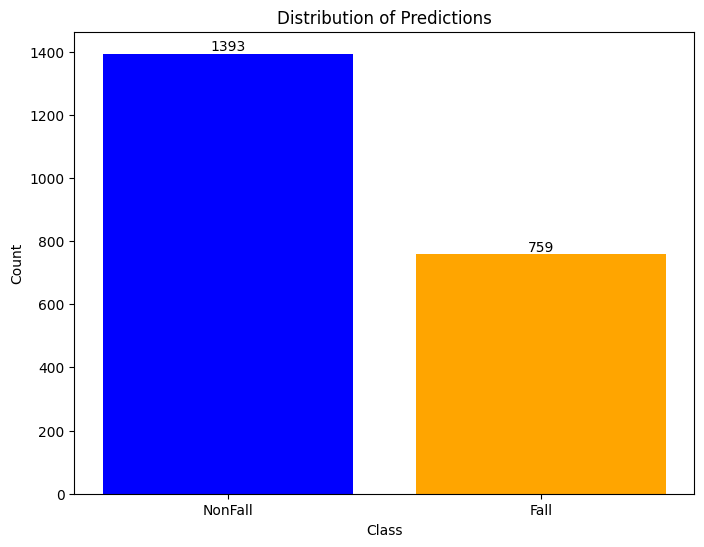

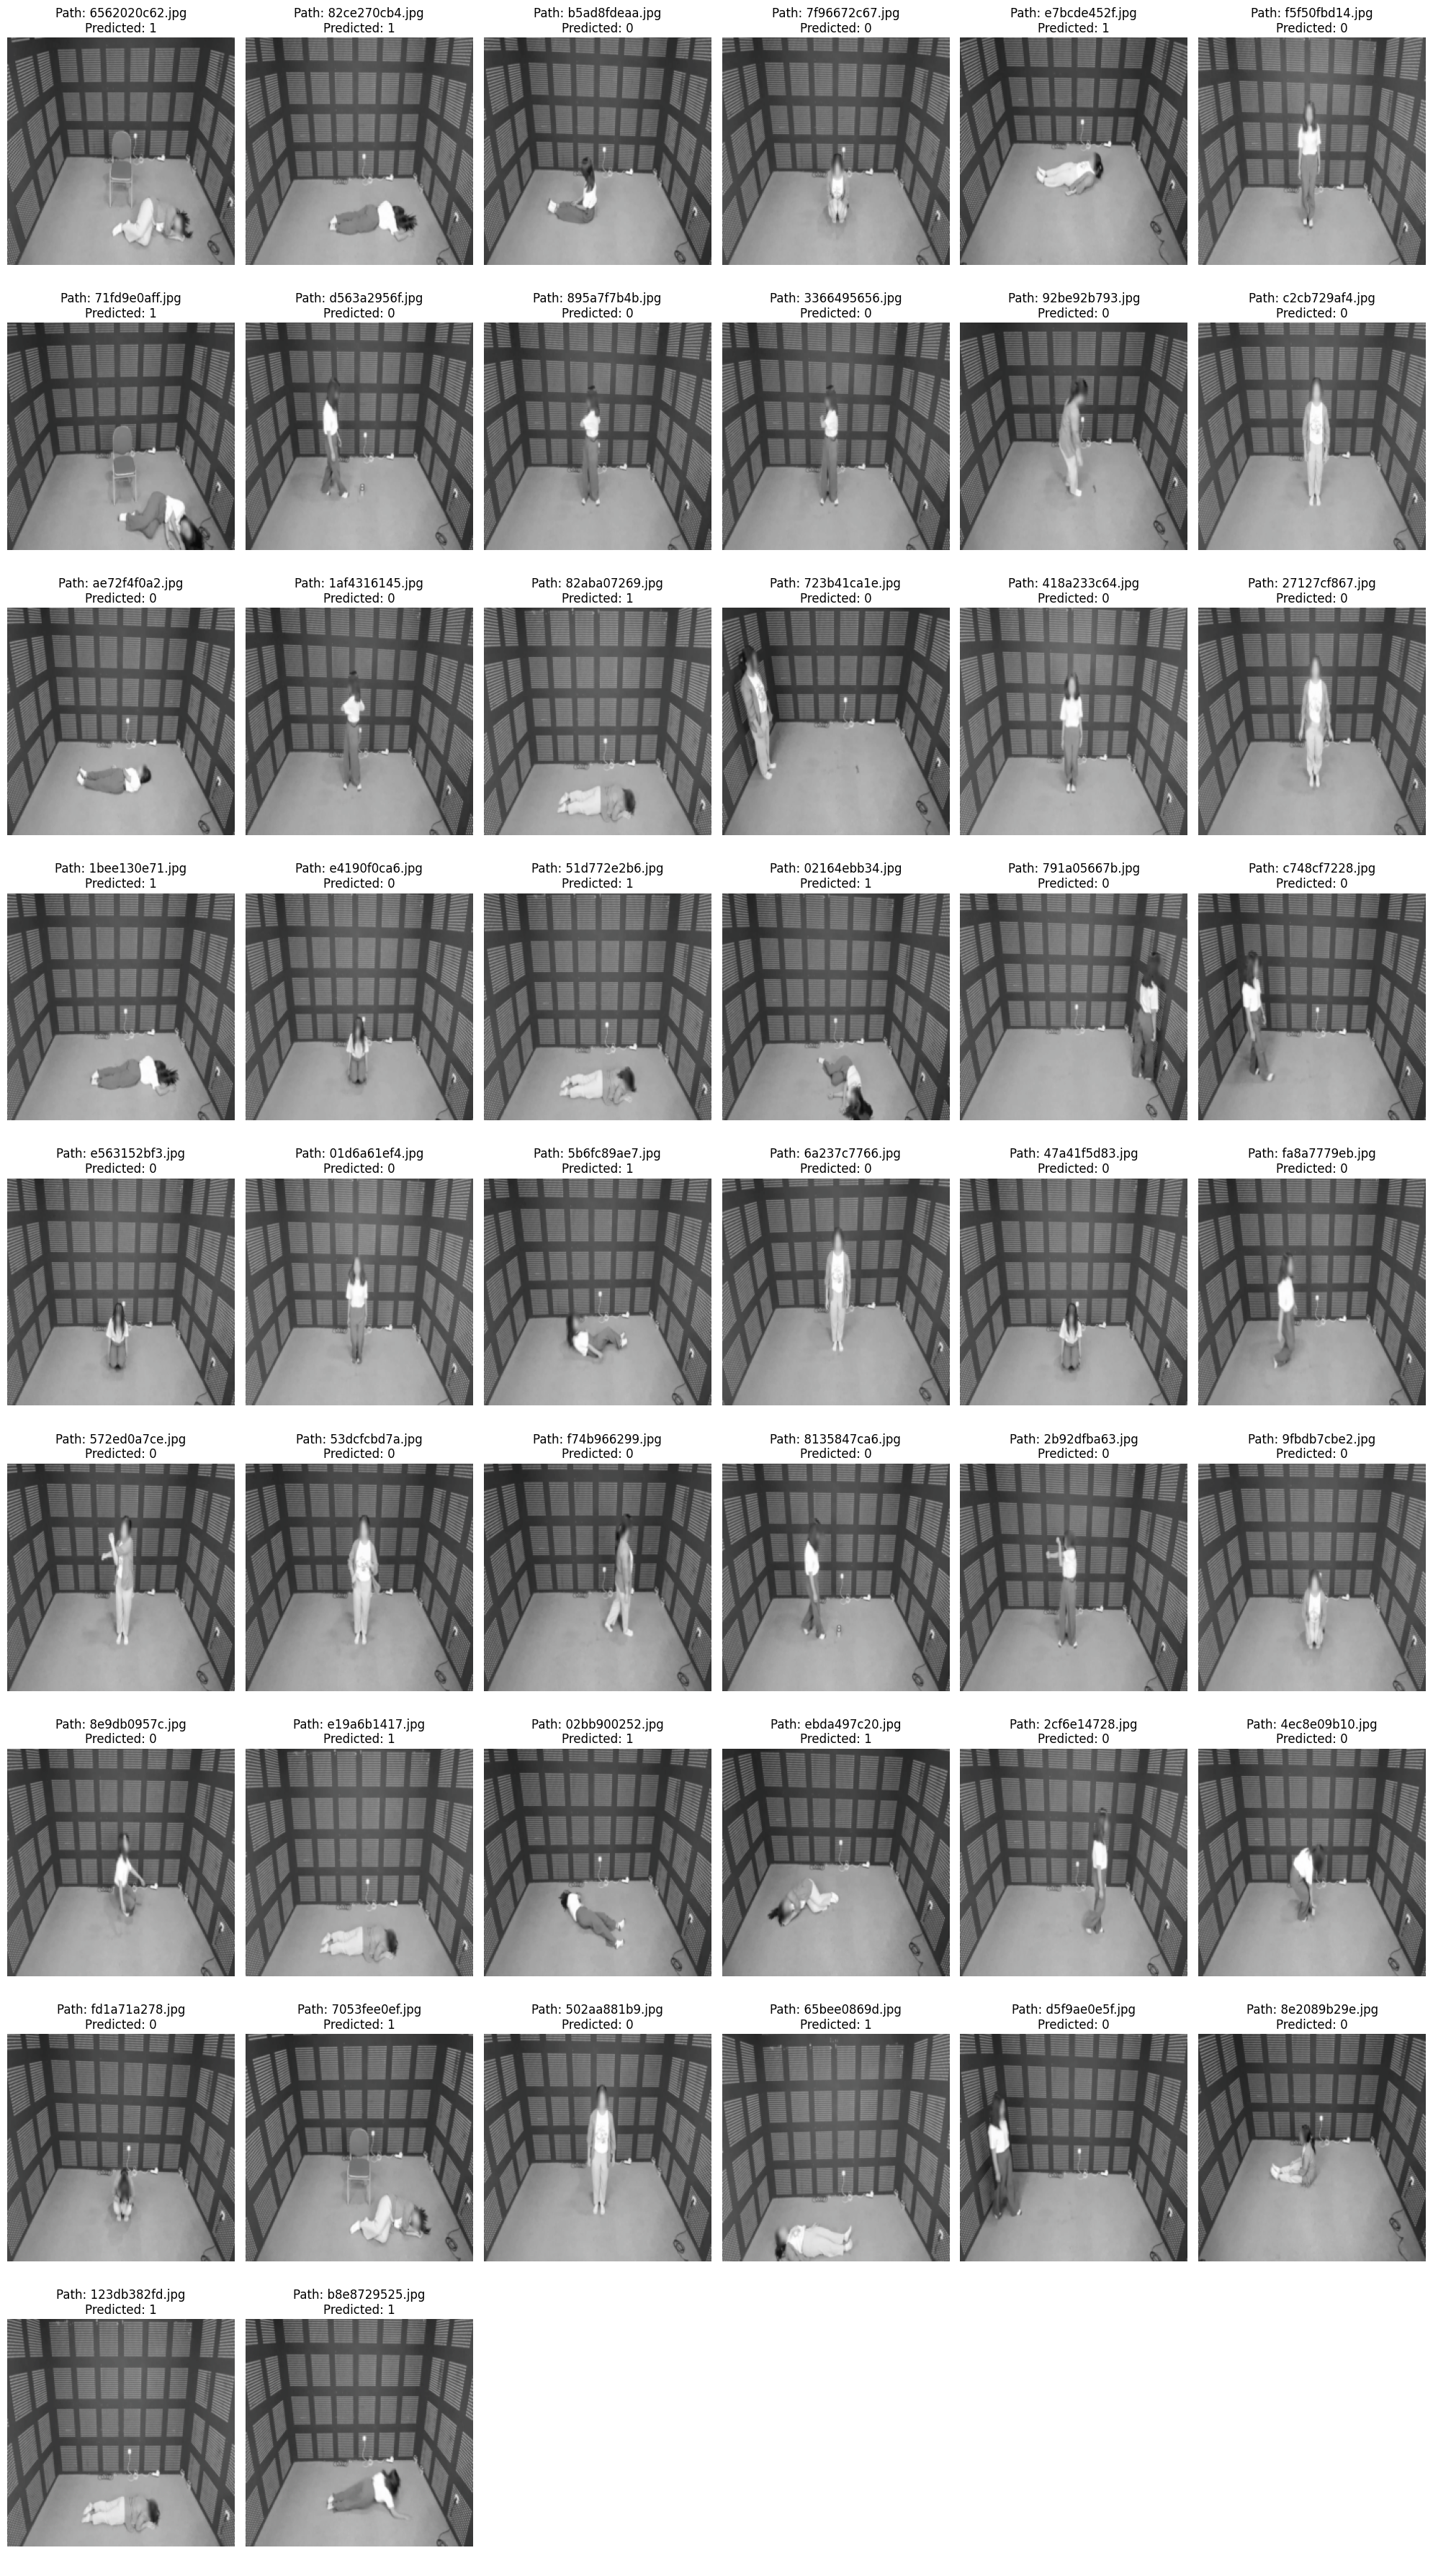

In [31]:
def evaluate_testing(model, testing_loader, device, stack_size=5, num_samples=50, csv_path='predictions1.csv'):
    """
    Evaluates the model on the testing dataset, visualizes random samples, and saves predictions to CSV.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        testing_loader (DataLoader): DataLoader for the testing dataset.
        device (torch.device): Device to perform computations on.
        stack_size (int): Number of frames to stack for model input.
        num_samples (int): Number of random samples to visualize.
        csv_path (str): Path to save the CSV file with predictions.
    """
    model.eval()

    all_preds = []
    all_paths = []

    sample_images = []
    sample_preds = []
    sample_paths = []

    total_samples = len(testing_loader.dataset)

    num_samples = min(num_samples, total_samples)

    random_indices = set(random.sample(range(total_samples), num_samples))

    with torch.no_grad():
        for batch_idx, (images, labels, img_paths) in enumerate(testing_loader):
            # Move data to the specified device
            images = images.to(device)
            labels = labels.to(device)  

            frame = images[0] 

            stacked_frames = frame.unsqueeze(1).repeat(1, stack_size, 1, 1) 
            stacked_frames = stacked_frames.unsqueeze(0) 

            assert stacked_frames.dim() == 5, f"Expected 5D tensor, got {stacked_frames.dim()}D tensor"

            outputs = model(stacked_frames)
            _, predicted = torch.max(outputs, 1)

            pred_label = predicted.item()

            img_path = img_paths[0]
            img_filename = os.path.basename(img_path)

            all_preds.append(pred_label)
            all_paths.append(img_filename)

            if batch_idx in random_indices and len(sample_images) < num_samples:
                img = frame.cpu().numpy()
                img = np.transpose(img, (1, 2, 0))  # [H, W, C]
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
                img = np.clip(img, 0, 1)
                sample_images.append(img)
                sample_preds.append(pred_label)
                sample_paths.append(img_filename)

    df = pd.DataFrame({
        'id': all_paths,
        'label': all_preds
    })

    df.to_csv(csv_path, index=False)

    print(f'Predictions saved to {csv_path}')
    
    distribution = df['label'].value_counts().sort_index()
    labels = ['NonFall', 'Fall']
    counts = distribution.tolist()
    plt.figure(figsize=(8,6))
    plt.bar(labels, counts, color=['blue', 'orange'])
    plt.title('Distribution of Predictions')
    plt.xlabel('Class')
    plt.ylabel('Count')
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.show()

    num_plots = len(sample_images)
    cols = 6  # Update columns to 6 to fit more images per row
    rows = (num_plots + cols - 1) // cols  # Calculate rows needed to fit images

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten()

    for i in range(num_plots):
        axes[i].imshow(sample_images[i])
        axes[i].set_title(f'Path: {sample_paths[i]}\nPredicted: {sample_preds[i]}')
        axes[i].axis('off')

    for i in range(num_plots, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# Change num_samples to 50 to evaluate 50 random samples
evaluate_testing(model, testing_loader, device, stack_size=5, num_samples=50, csv_path='predictions1.csv')

In [32]:
predictions_path = "/kaggle/working/predictions1.csv"
sample_submission_path = "/kaggle/input/sample/sample_submission.csv"
merged_output_path = "ganti1.csv"

predictions = pd.read_csv(predictions_path)

sample_submission = pd.read_csv(sample_submission_path)
merged = pd.merge(sample_submission, predictions, on='id', how='inner')

merged = merged[['id', 'label_y']].rename(columns={'label_y': 'label'})
merged.to_csv(merged_output_path, index=False)

print(f'Merged CSV saved to {merged_output_path}')

Merged CSV saved to ganti1.csv
